# 01 — Exploratory Data Analysis (EDA): Station–Day
**Author:** Joe Todaro

This notebook explores the **station–day** table produced in `00_data_build_station_day.ipynb`:
- Data coverage & basic profiling
- System seasonality (weekly/monthly)
- Station rankings & volatility
- Station-level seasonality (weekday profiles)
- Simple anomaly candidates via residual z-scores
- Initial hypotheses for modeling (per rubric)


## 1) Setup

In [1]:
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams['figure.figsize']=(10,5)
plt.rcParams['axes.grid']=True

DATA_INTERIM = '../data/interim'
P_SD = f'{DATA_INTERIM}/station_day.csv'
assert os.path.exists(P_SD), f'Missing file: {P_SD}'

print('Using:', P_SD)

Using: ../data/interim/station_day.csv


## 2) Load & Basic Profile

In [2]:
sd = pd.read_csv(P_SD, low_memory=False)
# parse dates
sd['date'] = pd.to_datetime(sd['date'], errors='coerce')
sd = sd.dropna(subset=['date'])
sd['station'] = sd['station'].astype(str).str.strip()
sd['ridership'] = pd.to_numeric(sd['ridership'], errors='coerce')

print('shape:', sd.shape)
print('columns:', list(sd.columns))
display(sd.head())

# Coverage
print('date min:', sd['date'].min(), '| date max:', sd['date'].max())
print('unique stations:', sd['station'].nunique())

# Missingness
miss = sd.isna().mean().sort_values(ascending=False)
display(miss)

shape: (15032, 6)
columns: ['date', 'station', 'ridership', 'is_holiday', 'dow', 'is_weekend']


,date,station,ridership,is_holiday,dow,is_weekend
0,2023-09-01,25 St (R),1,0,4,0
1,2023-09-01,"72 St (1,2,3)",1,0,4,0
2,2023-09-01,"86 St (C,B)",2862,0,4,0
3,2023-09-01,Baychester Av (5),1,0,4,0
4,2023-09-01,"Broad St (J,Z)",1,0,4,0


date min: 2023-09-01 00:00:00 | date max: 2024-06-20 00:00:00
unique stations: 428


date          0.0
station       0.0
ridership     0.0
is_holiday    0.0
dow           0.0
is_weekend    0.0
dtype: float64

## 3) System Seasonality

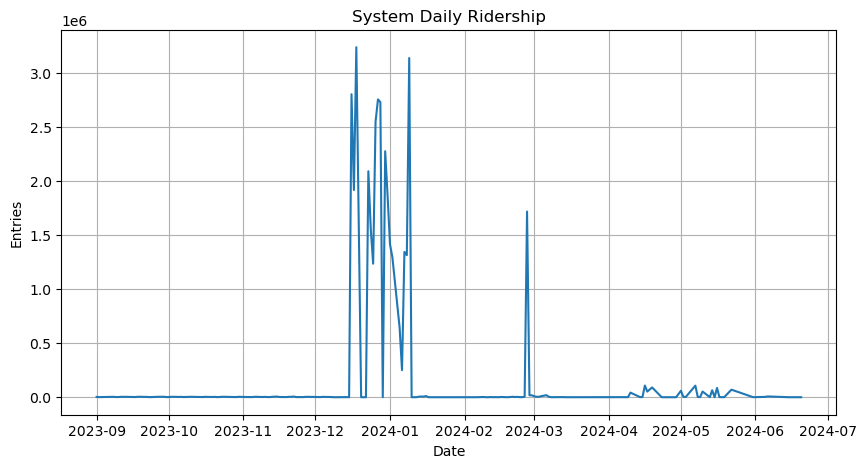

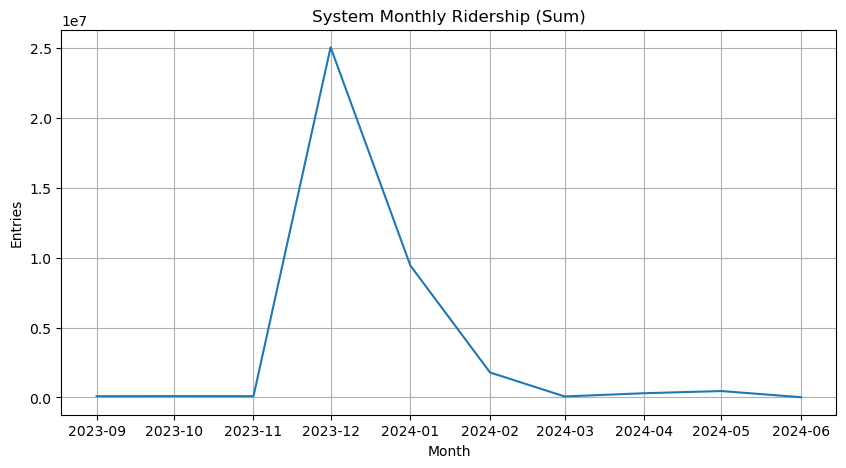

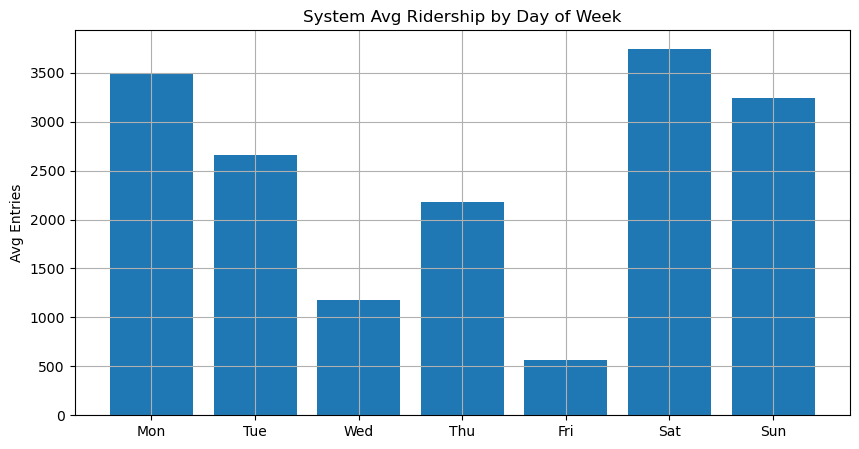

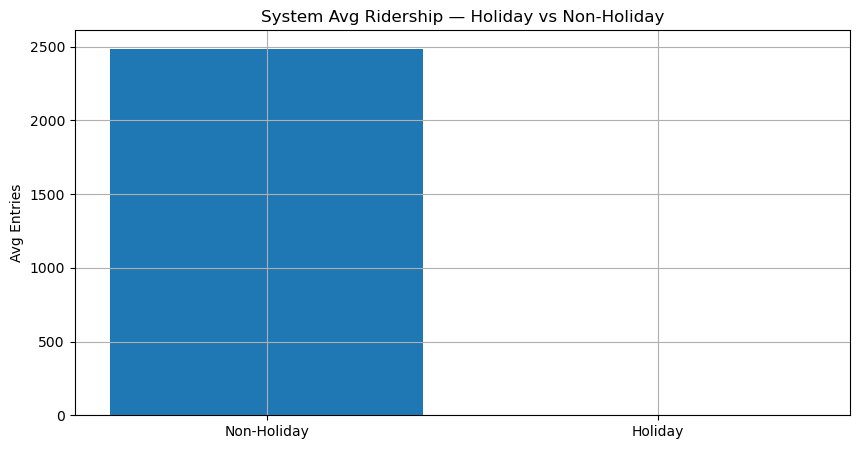

In [3]:
# Daily total
sys_daily = sd.groupby('date')['ridership'].sum().sort_index()
fig, ax = plt.subplots()
ax.plot(sys_daily.index, sys_daily.values)
ax.set_title('System Daily Ridership'); ax.set_ylabel('Entries'); ax.set_xlabel('Date')
plt.show()

# Monthly total (calendar month)
sys_month = sys_daily.resample('MS').sum()
fig, ax = plt.subplots()
ax.plot(sys_month.index, sys_month.values)
ax.set_title('System Monthly Ridership (Sum)'); ax.set_ylabel('Entries'); ax.set_xlabel('Month')
plt.show()

# Weekday pattern (system average)
sd['dow'] = sd['date'].dt.weekday
dow_avg = sd.groupby('dow')['ridership'].mean().reindex([0,1,2,3,4,5,6])
fig, ax = plt.subplots()
ax.bar(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], dow_avg.values)
ax.set_title('System Avg Ridership by Day of Week'); ax.set_ylabel('Avg Entries')
plt.show()

# Holiday vs non-holiday (if column exists)
if 'is_holiday' in sd.columns:
    hv = sd.groupby('is_holiday')['ridership'].mean().reindex([0,1]).fillna(0)
    fig, ax = plt.subplots()
    ax.bar(['Non-Holiday','Holiday'], hv.values)
    ax.set_title('System Avg Ridership — Holiday vs Non-Holiday'); ax.set_ylabel('Avg Entries')
    plt.show()
else:
    print("Column 'is_holiday' not present; skipping holiday comparison.")

## 4) Station Rankings & Distribution

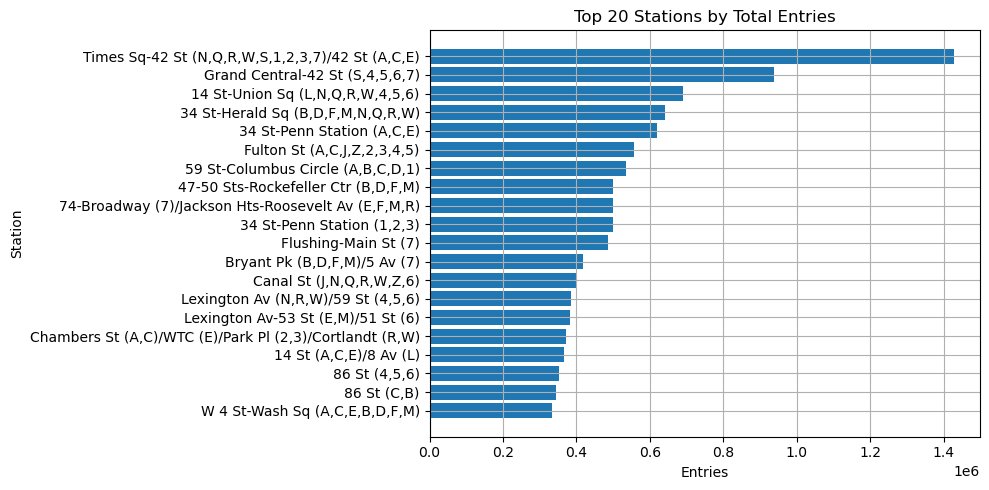

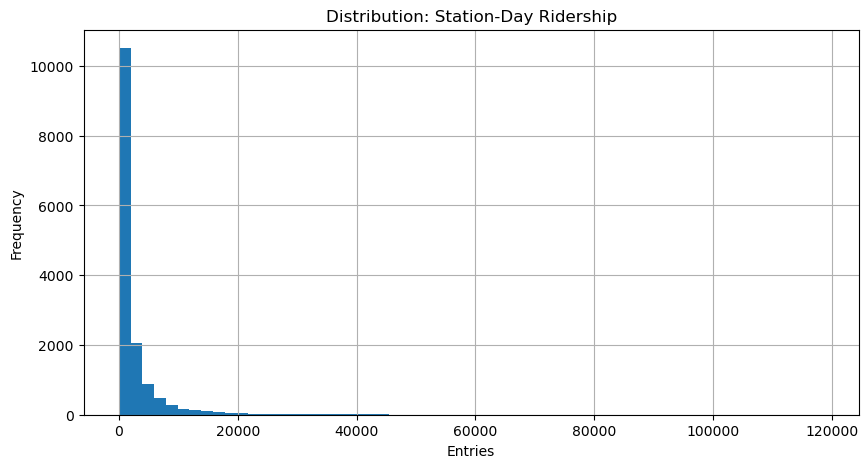

In [4]:
# Total volume per station (over the whole period)
station_totals = sd.groupby('station')['ridership'].sum().sort_values(ascending=False)
topN = 20
fig, ax = plt.subplots()
ax.barh(station_totals.head(topN).index[::-1], station_totals.head(topN).values[::-1])
ax.set_title(f'Top {topN} Stations by Total Entries'); ax.set_xlabel('Entries'); ax.set_ylabel('Station')
plt.tight_layout(); plt.show()

# Distribution of station-day ridership (log scale to handle skew)
fig, ax = plt.subplots()
vals = sd['ridership'].clip(lower=0)
ax.hist(vals, bins=60)
ax.set_title('Distribution: Station-Day Ridership'); ax.set_xlabel('Entries'); ax.set_ylabel('Frequency')
plt.show()

## 5) Station Volatility & Weekday Profiles

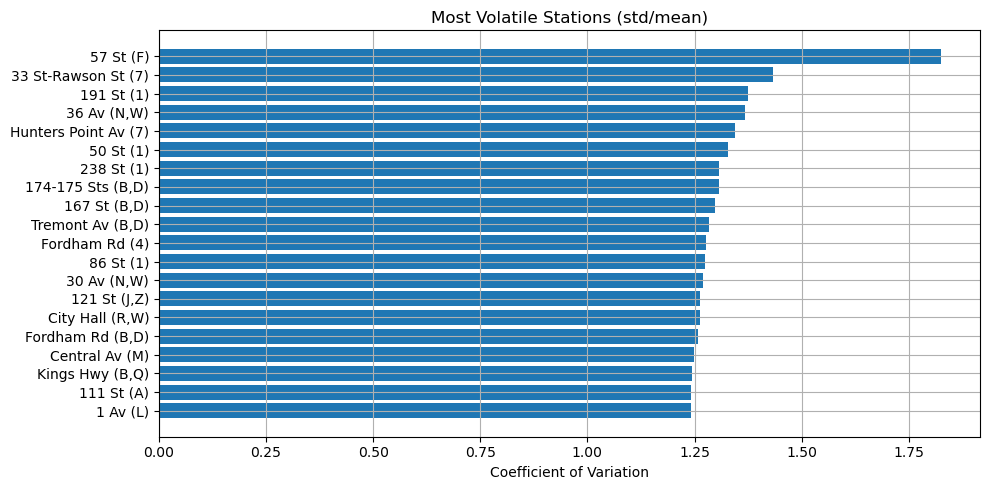

Weekday profiles for: ['Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)', 'Grand Central-42 St (S,4,5,6,7)', '14 St-Union Sq (L,N,Q,R,W,4,5,6)', '34 St-Herald Sq (B,D,F,M,N,Q,R,W)', '34 St-Penn Station (A,C,E)']


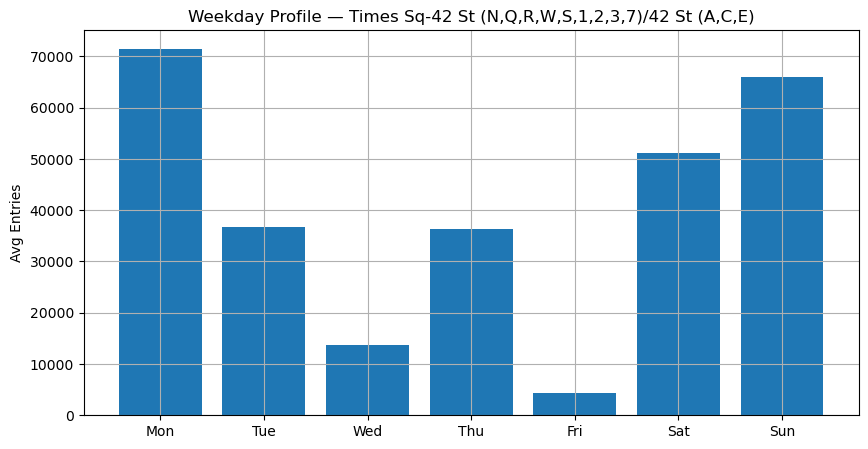

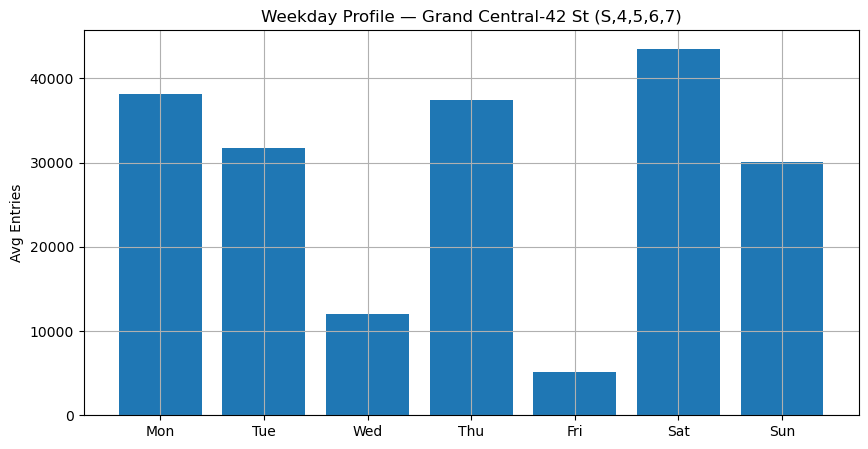

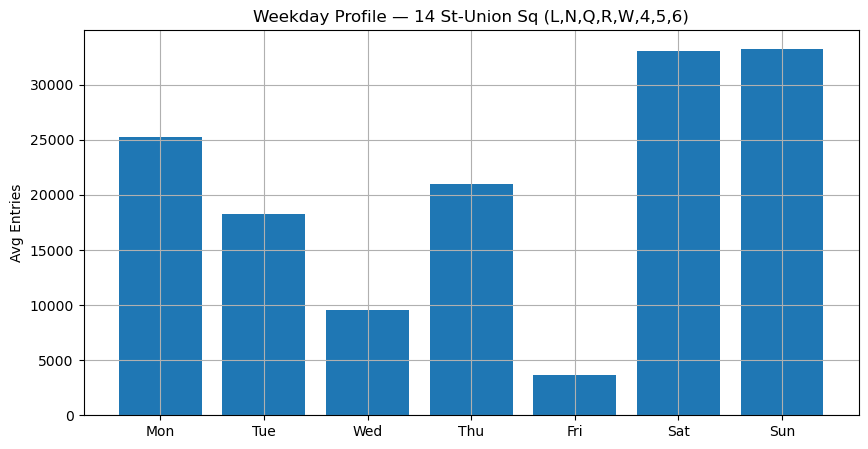

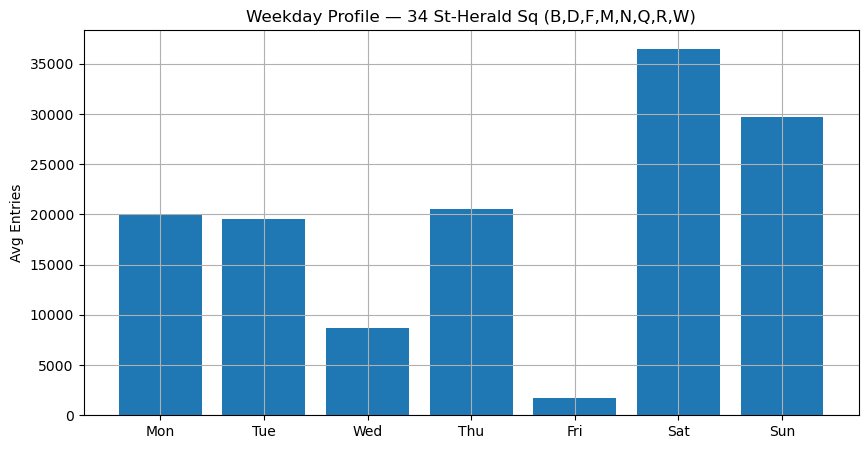

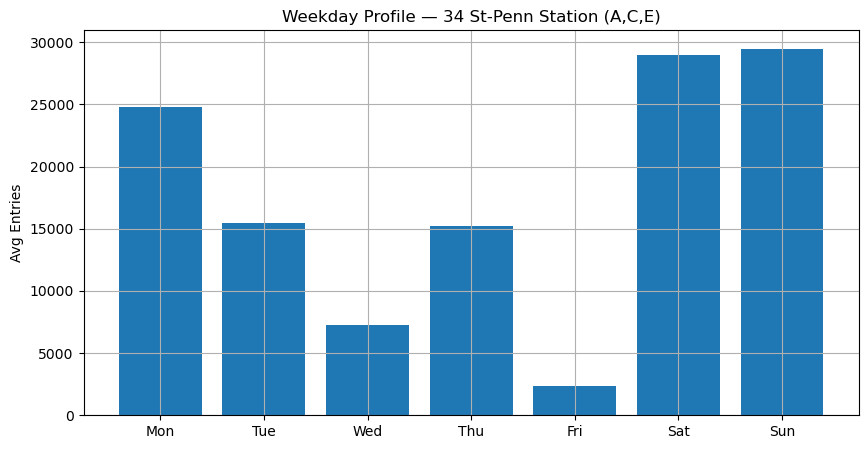

In [5]:
# Volatility: standard deviation per station (normalized by mean)
g = sd.groupby('station')['ridership']
vol = (g.std() / (g.mean()+1e-9)).sort_values(ascending=False)
fig, ax = plt.subplots()
ax.barh(vol.head(20).index[::-1], vol.head(20).values[::-1])
ax.set_title('Most Volatile Stations (std/mean)'); ax.set_xlabel('Coefficient of Variation')
plt.tight_layout(); plt.show()

# Weekday profiles for a few top stations
sel_stations = list(station_totals.head(5).index)
print('Weekday profiles for:', sel_stations)
for st in sel_stations:
    sub = sd[sd['station']==st]
    prof = sub.groupby(sub['date'].dt.weekday)['ridership'].mean().reindex([0,1,2,3,4,5,6])
    fig, ax = plt.subplots()
    ax.bar(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], prof.values)
    ax.set_title(f'Weekday Profile — {st}'); ax.set_ylabel('Avg Entries')
    plt.show()

## 6) Initial Hypotheses (to guide modeling)
- **H1 (Seasonality):** Weekday patterns dominate — Mon–Fri ridership significantly exceeds weekends.
- **H2 (Station Heterogeneity):** A small set of stations drive a disproportionate share of total ridership; these also show higher volatility.
- **H3 (Holidays):** Holidays reduce ridership relative to nearby non-holiday weekdays (effect size to be validated once holiday overlap exists in data window).
- **H4 (Anomalies):** Residual z-scores identify days of unusual station behavior (closures, events, device issues) worth flagging for MTA ops.

**Next:** build a features pipeline with lagged values (t-1, t-7, 7d/28d rolling stats) and train time-aware models with `TimeSeriesSplit`.
